# Time Series Forecasting Metrics

In time series forecasting, **evaluating the performance** of predictive models is crucial to ensure accurate and reliable forecasts. Forecasting metrics are quantitative measures used to assess the accuracy and effectiveness of these models. They help in comparing different models, diagnosing errors, and making informed decisions based on forecast results.

Skforecast is compatible with most of the metrics from scikit-learn and includes additional metrics specifically designed for time series forecasting.

**Regression Metrics**

These metrics are used when the target variable is **continuous** (e.g., predicting temperature, sales, or energy consumption).

+ Mean Squared Error ([`mean_squared_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html))

+ Mean Absolute Error ([`mean_absolute_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html))

+ Mean Absolute Percentage Error ([`mean_absolute_percentage_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html))

+ Symmetric Mean Absolute Percentage Error ([`symmetric_mean_absolute_percentage_error`](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error))

+ Mean Squared Log Error ([`mean_squared_log_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html))

+ Median Absolute Error ([`median_absolute_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.median_absolute_error.html))

+ Mean Absolute Scaled Error ([`mean_absolute_scaled_error`](https://en.wikipedia.org/wiki/Mean_absolute_scaled_error#:~:text=In%20statistics%2C%20the%20mean%20absolute,2005%20by%20statistician%20Rob%20J.))

+ Root Mean Squared Scaled Error (`root_mean_squared_scaled_error`)

**Classification Metrics**

These metrics are used when the target variable is **categorical** (e.g., predicting market direction, discrete events, or class intervals).

+ Accuracy Score ([`accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html))

+ Balanced Accuracy Score ([`balanced_accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html))

+ F1 Score ([`f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html))

+ Precision Score ([`precision_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html))

+ Recall Score ([`recall_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html))

**Custom Metrics**

In addition, Skforecast allows the user to define their own custom metrics. This can be done by creating a function that takes two arguments: the true values (`y_true`) and the predicted values (`y_pred`), and returns a single value representing the metric. The custom metric, optionally takes an additional argument `y_train` with the training data used to fit the model.

In most cases, the metrics are calculated using the predictions generated in a [backtesting](../user_guides/backtesting.html) process. For this, the `backtesting_forecaster` and `backtesting_forecaster_multiseries` functions take the `metrics` argument to specify the metric(s) to be calculated in addition to the predictions.

## Metrics for single series forecasting

The following code shows how to calculate metrics when a [single series is forecasted](../user_guides/autoregressive-forecaster.html). The example uses the `backtesting_forecaster` function to generate predictions and calculate the metrics.

In [1]:
# Libraries
# ==============================================================================
import pandas as pd
from lightgbm import LGBMRegressor
from skforecast.datasets import fetch_dataset
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold, backtesting_forecaster
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from skforecast.metrics import mean_absolute_scaled_error
from skforecast.plot import set_dark_theme

In [2]:
# Dowlnoad dataset
# ==============================================================================
data = fetch_dataset('website_visits', raw=True)
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%y')
data = data.set_index('date')
data = data.asfreq('1D')
data = data.sort_index()
data.head(3)

╭───────────────────────────── website_visits ──────────────────────────────╮
│ Description:                                                              │
│ Daily visits to the cienciadedatos.net website registered with the google │
│ analytics service.                                                        │
│                                                                           │
│ Source:                                                                   │
│ Amat Rodrigo, J. (2021). cienciadedatos.net (1.0.0). Zenodo.              │
│ https://doi.org/10.5281/zenodo.10006330                                   │
│                                                                           │
│ URL:                                                                      │
│ https://raw.githubusercontent.com/skforecast/skforecast-                  │
│ datasets/main/data/visitas_por_dia_web_cienciadedatos.csv                 │
│                                                                           │
│ Shape: 421 rows x 2 columns                                               │
╰───────────────────────────────────────────────────────────────────────────╯

,users
date,
2020-07-01,2324
2020-07-02,2201
2020-07-03,2146


In [3]:
# Backtesting to generate predictions over the test set and calculate metrics
# ==============================================================================
forecaster = ForecasterRecursive(
                 estimator = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 7
             )

metrics = [
    'mean_absolute_error',
    'mean_squared_error',
    'mean_absolute_percentage_error',
    'mean_absolute_scaled_error'
]

cv = TimeSeriesFold(steps=7, initial_train_size = len(data) // 2)

backtest_metrics, predictions = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data['users'],
                                    cv         = cv,
                                    metric     = metrics,
                                )
backtest_metrics

  0%|          | 0/31 [00:00<?, ?it/s]

,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error,mean_absolute_scaled_error
0,298.298903,165698.930884,0.176136,0.695103


It is possible to pass a list of functions instead of names. 

In [4]:
# Backtesting with callable metrics
# ==============================================================================
metrics = [
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    mean_absolute_scaled_error
]

backtest_metrics, predictions = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data['users'],
                                    cv         = cv,
                                    metric     = metrics,
                                )
backtest_metrics

  0%|          | 0/31 [00:00<?, ?it/s]

,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error,mean_absolute_scaled_error
0,298.298903,165698.930884,0.176136,0.695103


Since functions can be passed as arguments, it is possible to define custom metrics. The custom metric must be a function that takes two arguments: the true values (`y_true`) and the predicted values (`y_pred`), and returns a single value representing the metric. Optionally, it can take additional arguments `y_train` with the training data.

In [5]:
# Backtesting with custom metric
# ==============================================================================
def custom_metric(y_true, y_pred):
    """
    Calculate the mean absolute error excluding weekends.
    """
    mask = y_true.index.weekday < 5
    metric = mean_absolute_error(y_true[mask], y_pred[mask])

    return metric


backtest_metrics, predictions = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data['users'],
                                    cv         = cv,
                                    metric     = custom_metric,
                                )
backtest_metrics

  0%|          | 0/31 [00:00<?, ?it/s]

,custom_metric
0,298.375447


## Metrics for multiple time series forecasting

When working with multiple time series, it is common to calculate metrics across all series to get an overall measure of performance, in addition to individual values. Skforecast provides 3 different aggregation methods:

+ **average**: the average (arithmetic mean) of all levels.

+ **weighted_average**: the average of the metrics weighted by the number of predicted values of each level.

+ **pooling**: the values of all levels are pooled and then the metric is calculated.

To include the aggregated metrics in the output of `backtesting_forecaster_multiseries`, the `add_aggregated_metric` argument must be set to `True`.

In [6]:
# Libraries
# ==============================================================================
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from skforecast.datasets import fetch_dataset
from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.model_selection import backtesting_forecaster_multiseries
from skforecast.model_selection import grid_search_forecaster_multiseries

In [7]:
# Data download
# ==============================================================================
data = fetch_dataset(name="items_sales")
data.head()

╭─────────────────────── items_sales ───────────────────────╮
│ Description:                                              │
│ Simulated time series for the sales of 3 different items. │
│                                                           │
│ Source:                                                   │
│ Simulated data.                                           │
│                                                           │
│ URL:                                                      │
│ https://raw.githubusercontent.com/skforecast/skforecast-  │
│ datasets/main/data/simulated_items_sales.csv              │
│                                                           │
│ Shape: 1097 rows x 3 columns                              │
╰───────────────────────────────────────────────────────────╯

,item_1,item_2,item_3
date,,,
2012-01-01,8.253175,21.047727,19.429739
2012-01-02,22.777826,26.578125,28.009863
2012-01-03,27.549099,31.751042,32.078922
2012-01-04,25.895533,24.567708,27.252276
2012-01-05,21.379238,18.191667,20.357737


In [8]:
# Split data into train-val-test
# ==============================================================================
end_train = '2014-07-15 23:59:00'
data_train = data.loc[:end_train, :].copy()
data_test  = data.loc[end_train:, :].copy()

print(
    f"Train dates : {data_train.index.min()} --- {data_train.index.max()}   "
    f"(n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}   "
    f"(n={len(data_test)})"
)

Train dates : 2012-01-01 00:00:00 --- 2014-07-15 00:00:00   (n=927)
Test dates  : 2014-07-16 00:00:00 --- 2015-01-01 00:00:00   (n=170)


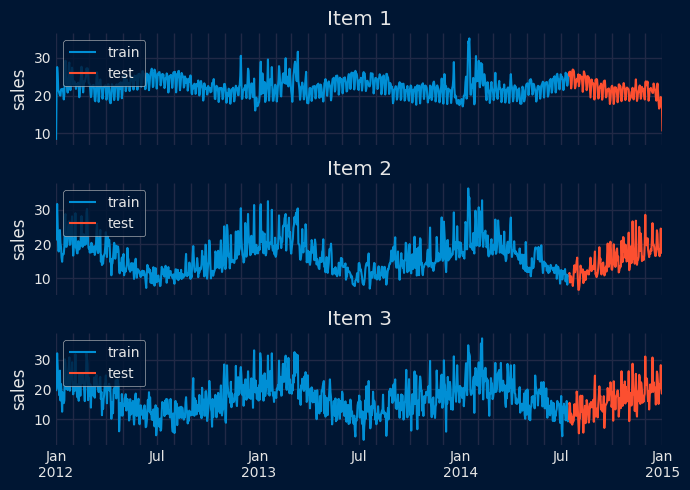

In [9]:
# Plot time series
# ==============================================================================
set_dark_theme()
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
for i, item in enumerate(['item_1', 'item_2', 'item_3'], start=0):
    data_train[item].plot(label='train', ax=axes[i])
    data_test[item].plot(label='test', ax=axes[i])
    axes[i].set_ylabel('sales')
    axes[i].set_title(f'Item {i + 1}')
    axes[i].set_xlabel('')
    axes[i].legend(loc='upper left')
fig.tight_layout()
plt.show()

In [10]:
# Create and fit a Forecaster Multi-Series
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
                 estimator = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 24,
                 encoding  = 'ordinal'
             )
forecaster.fit(series=data_train)

╭────────────────────────────────── InputTypeWarning ──────────────────────────────────╮
│ Passing a DataFrame (either wide or long format) as `series` requires additional     │
│ internal transformations, which can increase computational time. It is recommended   │
│ to use a dictionary of pandas Series instead. For more details, see:                 │
│ https://skforecast.org/latest/user_guides/independent-multi-time-series-forecasting. │
│ html#input-data                                                                      │
│                                                                                      │
│ Category : skforecast.exceptions.InputTypeWarning                                    │
│ Location :                                                                           │
│ c:\Users\jaesc2\Miniconda3\envs\skforecast_py13\Lib\site-packages\skforecast\utils\u │
│ tils.py:2368                                                                         │
│ Suppress : warnings.simplefilter('ignore', category=InputTypeWarning)                │
╰──────────────────────────────────────────────────────────────────────────────────────╯

In [11]:
# Backtesting forecaster on multiple time series
# ==============================================================================
metrics = [
    'mean_absolute_error',
    'mean_squared_error',
    'mean_absolute_percentage_error',
    'mean_absolute_scaled_error'
]

cv = TimeSeriesFold(steps=24, initial_train_size=len(data_train))

backtest_metrics, backtest_predictions = backtesting_forecaster_multiseries(
    forecaster            = forecaster,
    series                = data,
    cv                    = cv,
    levels                = None,
    metric                = metrics,
    add_aggregated_metric = True
)

print("Backtest metrics")
backtest_metrics

╭────────────────────────────────── InputTypeWarning ──────────────────────────────────╮
│ Passing a DataFrame (either wide or long format) as `series` requires additional     │
│ internal transformations, which can increase computational time. It is recommended   │
│ to use a dictionary of pandas Series instead. For more details, see:                 │
│ https://skforecast.org/latest/user_guides/independent-multi-time-series-forecasting. │
│ html#input-data                                                                      │
│                                                                                      │
│ Category : skforecast.exceptions.InputTypeWarning                                    │
│ Location :                                                                           │
│ c:\Users\jaesc2\Miniconda3\envs\skforecast_py13\Lib\site-packages\skforecast\utils\u │
│ tils.py:2368                                                                         │
│ Suppress : warnings.simplefilter('ignore', category=InputTypeWarning)                │
╰──────────────────────────────────────────────────────────────────────────────────────╯

  0%|          | 0/8 [00:00<?, ?it/s]

Backtest metrics


,levels,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error,mean_absolute_scaled_error
0,item_1,1.163837,2.748612,0.057589,0.762485
1,item_2,2.634182,12.358668,0.171335,1.118262
2,item_3,3.111351,16.096772,0.200664,0.840188
3,average,2.303123,10.401350,0.143196,0.906978
4,weighted_average,2.303123,10.401350,0.143196,0.906978
5,pooling,2.303123,10.401350,0.143196,0.910909


In [12]:
# Backtest predictions
# ==============================================================================
print("Backtest predictions")
backtest_predictions.head(4)

Backtest predictions


,level,fold,pred
2014-07-16,item_1,0,25.906323
2014-07-16,item_2,0,10.522491
2014-07-16,item_3,0,12.034587
2014-07-17,item_1,0,25.807194


When using the hyperparameter optimization functions, the metrics are computed for each level and then aggregated. The `aggregate_metric` argument determines the aggregation method(s) to be used. Some considerations when choosing the aggregation method are:

+ `'average'` and `'weighted_average'` will be different if the number of predicted values is different for each series (level).

+ When all series have the same number of predicted values, 'average', 'weighted_average' and 'pooling' are equivalent except for the case of scaled metrics (`mean_absolute_scaled_error`, `root_mean_squared_scaled_error`) as the naive forecast is calculated individually for each series.

In this example, `metric = ['mean_absolute_scaled_error', 'root_mean_squared_scaled_error']` and `aggregate_metric = ['weighted_average', 'average', 'pooling']` so that the following metrics are calculated:

+ mean_absolute_scaled_error__weighted_average, mean_absolute_scaled_error__average, mean_absolute_scaled_error__pooling

+ root_mean_squared_scaled_error__weighted_average, root_mean_squared_scaled_error__average, root_mean_squared_scaled_error__pooling

Since `return_best` is set to `True`, the best model is returned. The best model is the one that minimizes the metric obtained by the first specified metric and aggregation method, `mean_absolute_scaled_error__weighted_average`.

In [13]:
# Grid search Multi-Series
# ==============================================================================
forecaster = ForecasterRecursiveMultiSeries(
                 estimator = LGBMRegressor(random_state=123, verbose=-1),
                 lags      = 24,
                 encoding  = 'ordinal'
             )

lags_grid = [24, 48]
param_grid = {
    'n_estimators': [10, 20],
    'max_depth': [3, 7]
}

cv = TimeSeriesFold(steps=24, initial_train_size=len(data_train), refit=False)

levels = ['item_1', 'item_2', 'item_3']

results = grid_search_forecaster_multiseries(
              forecaster       = forecaster,
              series           = data,
              lags_grid        = lags_grid,
              param_grid       = param_grid,
              cv               = cv,
              levels           = levels,  # Same as levels = None
              metric           = ['mean_absolute_scaled_error', 'root_mean_squared_scaled_error'],
              aggregate_metric = ['weighted_average', 'average', 'pooling'],
          )

results

╭────────────────────────────────── InputTypeWarning ──────────────────────────────────╮
│ Passing a DataFrame (either wide or long format) as `series` requires additional     │
│ internal transformations, which can increase computational time. It is recommended   │
│ to use a dictionary of pandas Series instead. For more details, see:                 │
│ https://skforecast.org/latest/user_guides/independent-multi-time-series-forecasting. │
│ html#input-data                                                                      │
│                                                                                      │
│ Category : skforecast.exceptions.InputTypeWarning                                    │
│ Location :                                                                           │
│ c:\Users\jaesc2\Miniconda3\envs\skforecast_py13\Lib\site-packages\skforecast\utils\u │
│ tils.py:2368                                                                         │
│ Suppress : warnings.simplefilter('ignore', category=InputTypeWarning)                │
╰──────────────────────────────────────────────────────────────────────────────────────╯

lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
  Parameters: {'max_depth': 7, 'n_estimators': 20}
  Backtesting metric: 0.8965371058488802
  Levels: ['item_1', 'item_2', 'item_3']



,levels,lags,lags_label,params,mean_absolute_scaled_error__weighted_average,mean_absolute_scaled_error__average,mean_absolute_scaled_error__pooling,root_mean_squared_scaled_error__weighted_average,root_mean_squared_scaled_error__average,root_mean_squared_scaled_error__pooling,max_depth,n_estimators
0,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 7, 'n_estimators': 20}",0.896537,0.896537,0.891585,0.873490,0.873490,0.862816,7,20
1,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 20}",0.968697,0.968697,0.946763,0.927639,0.927639,0.896254,3,20
2,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 7, 'n_estimators': 20}",0.970085,0.970085,0.962275,0.930273,0.930273,0.921523,7,20
3,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 20}",0.992591,0.992591,0.971936,0.937760,0.937760,0.910280,3,20
4,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 7, 'n_estimators': 10}",1.295626,1.295626,1.213049,1.172435,1.172435,1.077139,7,10
5,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 10}",1.369425,1.369425,1.292356,1.237487,1.237487,1.143031,3,10
6,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 10}",1.378819,1.378819,1.291499,1.244084,1.244084,1.140353,3,10
7,"[item_1, item_2, item_3]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 7, 'n_estimators': 10}",1.410147,1.410147,1.317691,1.277628,1.277628,1.172467,7,10


## Metrics for forecasting classification

Skforecast also allows to perform [forecasting classification tasks](../user_guides/autoregressive-classification-forecasting.html). In this case, the metrics used to evaluate the performance of the models are classification metrics.

In [14]:
# Libraries
# ==============================================================================
import pandas as pd
from lightgbm import LGBMClassifier
from skforecast.datasets import fetch_dataset
from skforecast.recursive import ForecasterRecursiveClassifier
from skforecast.model_selection import TimeSeriesFold, backtesting_forecaster
from sklearn.metrics import accuracy_score
from skforecast.plot import set_dark_theme

In [15]:
# Data download
# ==============================================================================
data = fetch_dataset(name='vic_electricity_classification')
data

╭──────────────────────── vic_electricity_classification ────────────────────────╮
│ Description:                                                                   │
│ Hourly electricity demand for Victoria, Australia classified into three        │
│ categories: 'low', 'medium' and 'high' according to the 20th and 80th          │
│ percentiles. The dataset also includes temperature, holiday indicator and hour │
│ of the day as features.                                                        │
│                                                                                │
│ Source:                                                                        │
│ O'Hara-Wild M, Hyndman R, Wang E, Godahewa R (2022).tsibbledata: Diverse       │
│ Datasets for 'tsibble'. https://tsibbledata.tidyverts.org/,                    │
│ https://github.com/tidyverts/tsibbledata/.                                     │
│ https://tsibbledata.tidyverts.org/reference/vic_elec.html                      │
│                                                                                │
│ URL:                                                                           │
│ https://raw.githubusercontent.com/skforecast/skforecast-                       │
│ datasets/main/data/vic_electricity_classification.csv                          │
│                                                                                │
│ Shape: 8736 rows x 5 columns                                                   │
╰────────────────────────────────────────────────────────────────────────────────╯

,Demand,Temperature,Holiday,Hour_of_day,Demand_raw
Time,,,,,
2014-01-01 01:00:00,low,24.80,1.0,1,3730.065980
2014-01-01 02:00:00,medium,25.90,1.0,2,3858.473927
2014-01-01 03:00:00,medium,25.30,1.0,3,3851.415438
2014-01-01 04:00:00,medium,23.65,1.0,4,3838.972926
2014-01-01 05:00:00,medium,20.70,1.0,5,3860.540970
...,...,...,...,...,...
2014-12-30 20:00:00,low,12.10,0.0,20,3527.232855
2014-12-30 21:00:00,medium,12.30,0.0,21,3846.439766
2014-12-30 22:00:00,medium,14.05,0.0,22,3961.529675


In [16]:
# Distribution of classes in the series
# ==============================================================================
print("Distribution of classes:")
data['Demand'].value_counts(normalize=True).round(2)

Distribution of classes:


Demand
medium    0.6
low       0.2
high      0.2
Name: proportion, dtype: float64

In [17]:
# Split train-test
# ==============================================================================
end_train = '2014-10-31 23:59:00'
data_train = data[:end_train].copy()
data_test  = data[end_train:].copy()

print(
    f"Train dates : {data_train.index.min()} --- "
    f"{data_train.index.max()}  (n={len(data_train)})"
)
print(
    f"Test dates  : {data_test.index.min()} --- "
    f"{data_test.index.max()}  (n={len(data_test)})"
)

Train dates : 2014-01-01 01:00:00 --- 2014-10-31 23:00:00  (n=7295)
Test dates  : 2014-11-01 00:00:00 --- 2014-12-31 00:00:00  (n=1441)


In [18]:
# Data preprocessing
# ==============================================================================
# Encode categorical variable as numerical for plotting
encode_mapping = {'low': 0, 'medium': 1, 'high': 2}
print(f"Encoding map: {encode_mapping}")
data['encoded_value'] = data['Demand'].map(encode_mapping).astype(float)
data_train['encoded_value'] = data_train['Demand'].map(encode_mapping).astype(float)
data_test['encoded_value'] = data_test['Demand'].map(encode_mapping).astype(float)
data.head(3)

Encoding map: {'low': 0, 'medium': 1, 'high': 2}


,Demand,Temperature,Holiday,Hour_of_day,Demand_raw,encoded_value
Time,,,,,,
2014-01-01 01:00:00,low,24.8,1.0,1,3730.065980,0.0
2014-01-01 02:00:00,medium,25.9,1.0,2,3858.473927,1.0
2014-01-01 03:00:00,medium,25.3,1.0,3,3851.415438,1.0


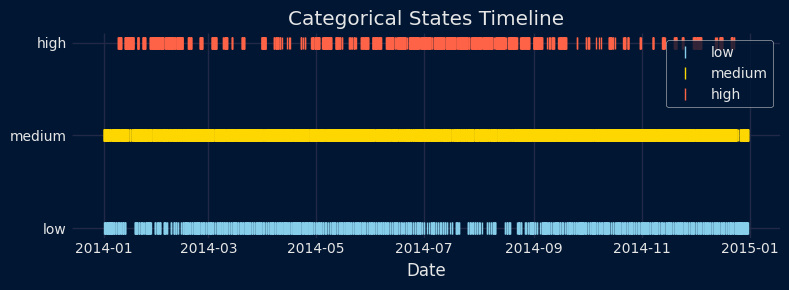

In [19]:
# Plot: states timeline
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
color_map = {"low": "skyblue", "medium": "gold", "high": "tomato"}
for state, color in color_map.items():
    mask = data["Demand"] == state
    ax.plot(
        data.index[mask], [state] * mask.sum(), '|', color=color, markersize=8, label=state
    )

ax.set_yticks(list(encode_mapping.values()))
ax.set_title("Categorical States Timeline")
ax.set_xlabel("Date")
ax.legend()
plt.tight_layout()
plt.show()

The `backtesting_forecaster` allows the use of [custom metrics](../user_guides/backtesting.html#backtesting-with-custom-metric) to evaluate forecaster performance.

This is particularly useful for classification tasks, as it enables metrics to be tailored to the specific problem type (e.g., binary, multi-class, or multi-label). Common examples include [`f1_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), [`roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html), and [`precision_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html).

In [20]:
# Custom f1-score for multi-class classification
# ==============================================================================
from sklearn.metrics import f1_score

def custom_f1_score(y_true, y_pred):
    """
    Custom f1-score metric, it must have `y_true` and `y_pred` as parameters.
    """
    return f1_score(y_true, y_pred, average='weighted')

In [21]:
# Create and fit forecaster with rolling window features
# ==============================================================================
forecaster = ForecasterRecursiveClassifier(
                 estimator         = LGBMClassifier(random_state=123, verbose=-1),
                 lags              = 24,
                 features_encoding = 'auto', 
             )

cv = TimeSeriesFold(steps = 24, initial_train_size = end_train)

metrics, predictions = backtesting_forecaster(
                           forecaster    = forecaster,
                           y             = data['Demand'],
                           exog          = data[['Temperature', 'Holiday', 'Hour_of_day']],
                           cv            = cv,
                           metric        = ['accuracy_score', custom_f1_score],
                           n_jobs        = 'auto',
                           verbose       = False,
                           show_progress = True
                       )

print("Backtest metrics")
metrics

  0%|          | 0/61 [00:00<?, ?it/s]

Backtest metrics


,accuracy_score,custom_f1_score
0,0.830673,0.82638
